# DATA2 -  RF - baseline - SHAP feature importacne

## Features
1. 'AGE'
1. 'RAVLT\_immediate'
1. 'AVDEL30MIN\_neuro'
1. 'AVDELTOT\_neuro'
1. 'TRAASCOR\_neuro'
1. 'TRABSCOR\_neuro'
1. 'CATANIMSC\_neuro'
1. 'GDTOTAL\_gds'
1. 'LRHHC\_n\_long'
1. 'LRLV\_n\_long'
1. 'FAQ'
1. 'Gender\_num\_'
1. 'Subgroup\_'
1. 'Subgroup\_num\_'
1. 'Usage\_'
---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. [An overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf)


The latest changes (ver. 0.01):

    - ver. 0.01 (2021.10.06)
        - shap values 
    
   *Created: 2021.10.06 / Updated: 2021.10.06*
   
---

#### IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display, SVG, Image
from eli5.sklearn import PermutationImportance

In [3]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs
import mci_rf_bl as mrfbl
import mci_permutation as mperm

In [4]:
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold


from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import plot_partial_dependence

#### GLOBAL PATH VARIABLES

In [5]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20210420' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [6]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: mk-prec-7540
Operating system: Linux, 64bit

Python path: /home/marek/miniconda3/envs/mci/bin/python
Python version: 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
[GCC 9.3.0]



,module,version
4,eli5,0.11.0
6,ipywidgets,7.6.3
10,matplotlib,3.1.1
12,numpy,1.20.3
14,pandas,1.2.4
15,pdpbox,0.2.1
19,scipy,1.6.3
20,seaborn,0.11.1
22,sklearn,0.24.2
23,statsmodels,0.12.2


---

##  FEATURES TO FEED A MODEL - THESE GLOBAL VARIABLES MUST BE UPDATED IN EACH NOTEBOOK SEPARATELY!!! 

In [7]:
FEATURES = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'GDTOTAL_gds', 'LRHHC_n_long','LRLV_n_long', 'FAQ',
            'Subgroup_', 'Subgroup_num_', 'Usage_',
           'Gender_num_', 'PTGENDER'
           ]


# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '3.02_RF-bl-permutation'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]


FILE_NAME_WITH_GS_MODEL_TO_LOAD = '3.01_RF-bl-neuropsych-MRI-FAQ-GDS'

# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 10

# display all stuff
VERBOSE = True

---

## LOAD BASELINE FILE AND RESTRICT COLUMN RANGE TO SELECTED FEATURES ONLY (FEATURES + Subgroup\_ x2 + Usage\_)

In [8]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	16


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [9]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease forfurther manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

## TRAIN / TEST SETS SHORT INFO

In [10]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [11]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-long-_')

Total number of columns: 16



,adni (#4),neuro (#5),long (#2),ours (#4)
0,AGE,AVDEL30MIN_neuro,LRHHC_n_long,Gender_num_
1,FAQ,AVDELTOT_neuro,LRLV_n_long,Subgroup_
2,PTGENDER,CATANIMSC_neuro,,Subgroup_num_
3,RAVLT_immediate,TRAASCOR_neuro,,Usage_
4,,TRABSCOR_neuro,,


---

## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [12]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 540
 - Test set: 140


---

# RANDOM FORESTS CLASSIFICATION

---

## CREATE X AND y

In [13]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

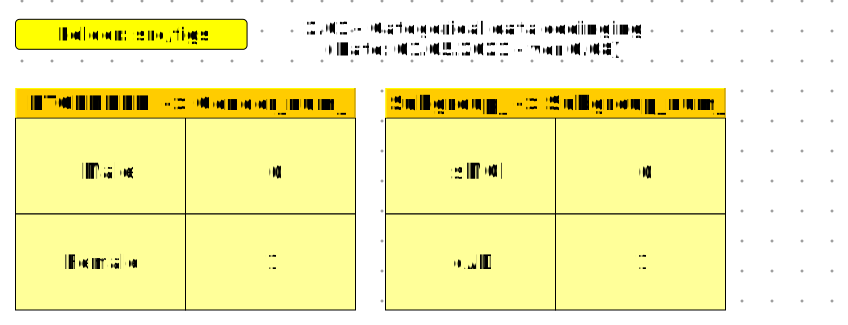

In [14]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

---

## REMOVE `SUBGROUP_`, `Subgroup_num_` and `Usage_` COLUMNS FROM THE TRAIN & TEST SETS

In [15]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'Gender_num_', 'PTGENDER']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: Gender_num_
		Removed: PTGENDER
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: Gender_num_
		Removed: PTGENDER


In [16]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']



---

# LOAD GRID SEARCH RESULTS FROM A FILE

In [17]:
# A filename of the the whole gridsearch structure
# LOAD A GS RESULT FORM A 3.01_RF-bl-neuropsych-MRI-FAQ-GDS by AV FILE!!!!
file_name_prefix_ext =  FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
grid = joblib.load(file_name_prefix_path)     
    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('\nBest params are stored in the variable: BEST_PARAMS')
BEST_PARAMS = grid.best_params_

GridSearch parameters loaded from a file:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.01_RF-bl-neuropsych-MRI-FAQ-GDS-GS-model.pkl

Best score: 0.769

Best params:
	bootstrap: False
	criterion: gini
	max_depth: 6
	max_features: 2
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 65

Best params are stored in the variable: BEST_PARAMS


---

# TEST SET

---

## TRAIN THE RF CLASSIFIER AND PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [18]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.736
0.736


## `TEST SET` SCORES (F1, ACCURACY, RECALL, PRECISION)

In [19]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.709
ACC: 0.736
RECALL: 0.692
PREC: 0.726


## CONFUSIOM MATRIX

#### PREDICTIONS

In [20]:
bl_test_pred = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=False, results_dir=RESULTS_DIR)


Subjects in the predictions table: 140



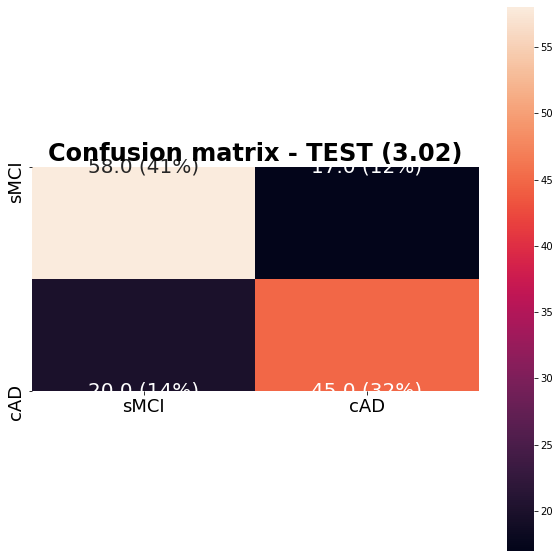

In [21]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matrix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST(conf_matrix_test, conf_matrix_test_prc, file_name_number=FILE_NAME_NUMBER, file_name_prefix=FILE_NAME_PREFIX,
                                 save=False, results_dir=RESULTS_DIR)

In [ ]:
matp

## FEATURE IMPORTANCE

In [22]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

FAQ                 0.196961
RAVLT_immediate     0.180133
LRHHC_n_long        0.150269
AVDEL30MIN_neuro    0.131718
TRAASCOR_neuro      0.059286
TRABSCOR_neuro      0.057993
AVDELTOT_neuro      0.055087
AGE                 0.054757
LRLV_n_long         0.054042
CATANIMSC_neuro     0.038786
GDTOTAL_gds         0.020969


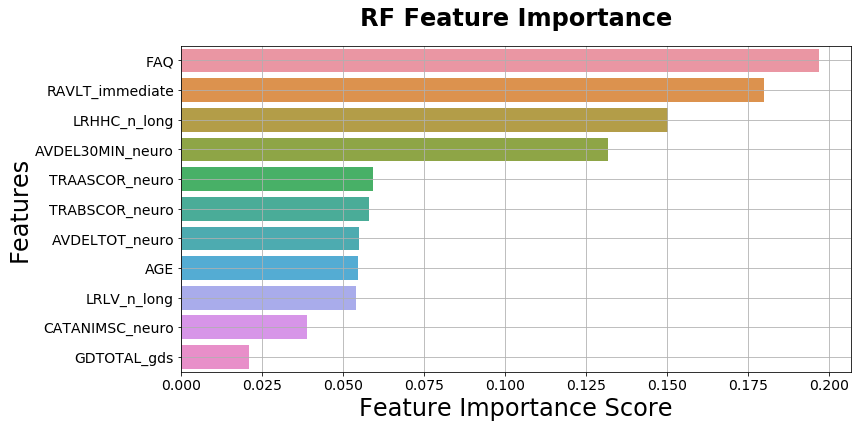

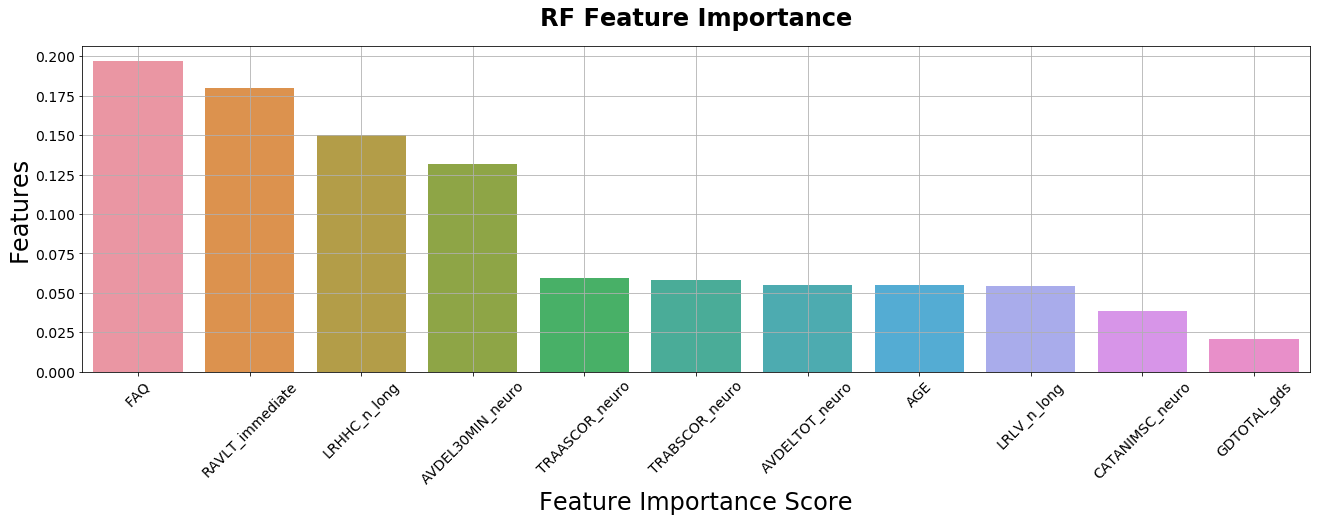

In [23]:
mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR, save=False)

mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='v', figsize=(22,6), results_dir = RESULTS_DIR, save=False)

---

## CORELATION (OPTIONAL)

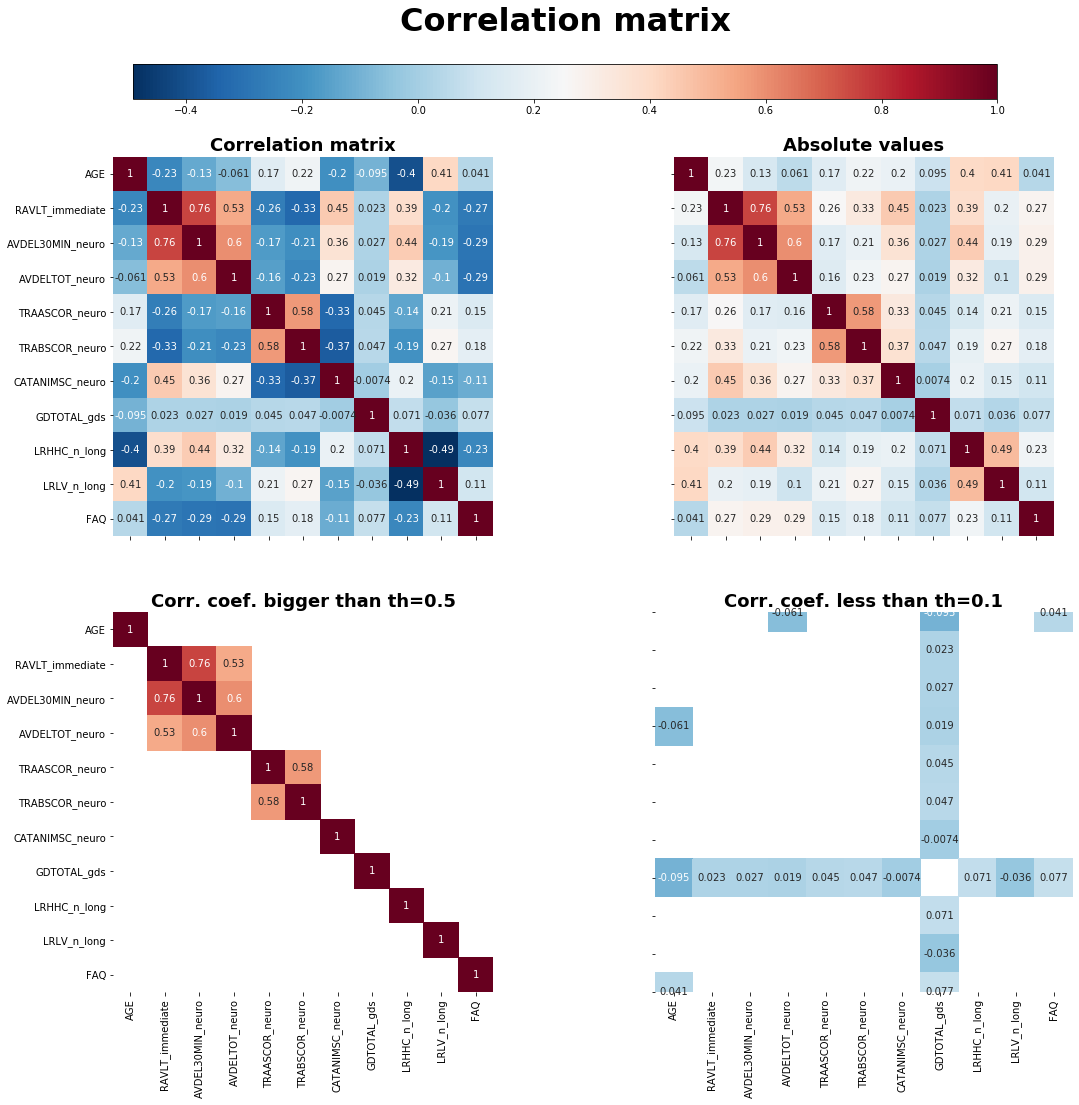

In [24]:
if VERBOSE:
    cor = X_train.corr()
    mn, mx = cor.values.min(), cor.values.max()
    cor_abs = X_train.corr().abs()    
    th1, th2 = 0.5, 0.1
    cor_th1 = cor[cor_abs>th1]
    cor_th2 = cor[cor_abs<th2]
    
    
    
    f,ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,16))
    sns.heatmap(cor, annot=True, cmap='RdBu_r', ax=ax[0,0], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_abs, annot=True, cmap='RdBu_r', ax=ax[0,1], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_th1, annot=True, cmap='RdBu_r', ax=ax[1,0], vmin=mn, vmax=mx, cbar=False)    
    sns.heatmap(cor_th2, annot=True, cmap='RdBu_r', ax=ax[1,1], vmin=mn, vmax=mx, cbar=False) 
    
    titles = ['Correlation matrix', 'Absolute values', f'Corr. coef. bigger than th={th1}', f'Corr. coef. less than th={th2}']
    for i,a in enumerate(ax.flat[:]):        
        a.set_aspect(aspect=1)
        a.set_title(titles[i], fontsize=18, fontweight='bold')
    
    
    cax = f.add_axes([0.2, 0.90, 0.6, 0.03])
    norm = plt.Normalize(mn, mx)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    f.colorbar(sm, cax=cax, orientation='horizontal')

    plt.suptitle('Correlation matrix', fontsize=32, fontweight='bold')
    plt.subplots_adjust(wspace=0.01, top=0.85)
    #plt.tight_layout(rect=[0,0,1,0.85])

---

# SHAP VALUES (2021.10.06)

In [26]:
import shap

In [27]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=6, max_features=2,
                       min_samples_leaf=2, n_estimators=65, random_state=42)

In [28]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

In [29]:
print(shap_values.values.shape)
print(shap_values.base_values.shape)
print(explainer.expected_value.shape)

(140, 11, 2)
(140, 2)
(2,)


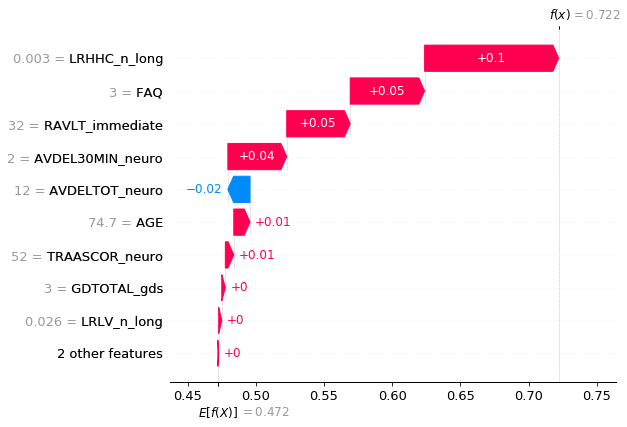

In [32]:
# https://github.com/slundberg/shap/issues/1420
row = 13
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names
        

shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(X_test)[1][row,:],
                         feature_names = X_test.columns,
                         data = X_test.iloc[row,:])

shap.waterfall_plot(shap_object)

In [132]:
shap.__version__

'0.39.0'

In [154]:
import shap
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(X_test)

#shap_imp_pd = pd.DataFrame(index=X_test.index, data = np.mean(np.absolute(shap_values), axis = 0), columns=["FAQ"])

#shap_imp_pd.sort_values(by=['Importance']).plot.barh(y='Importance')

In [175]:
shap_imp_pd=pd.DataFrame(
    index=X_test.columns, 
    data = np.mean(np.absolute(shap_values), axis = 0).mean(0), columns=['Importance'])

In [176]:
shap_imp_pd

,Importance
AGE,0.010339
RAVLT_immediate,0.078788
AVDEL30MIN_neuro,0.052839
AVDELTOT_neuro,0.020355
TRAASCOR_neuro,0.018119
TRABSCOR_neuro,0.013347
CATANIMSC_neuro,0.008820
GDTOTAL_gds,0.004563
LRHHC_n_long,0.066258
LRLV_n_long,0.008564


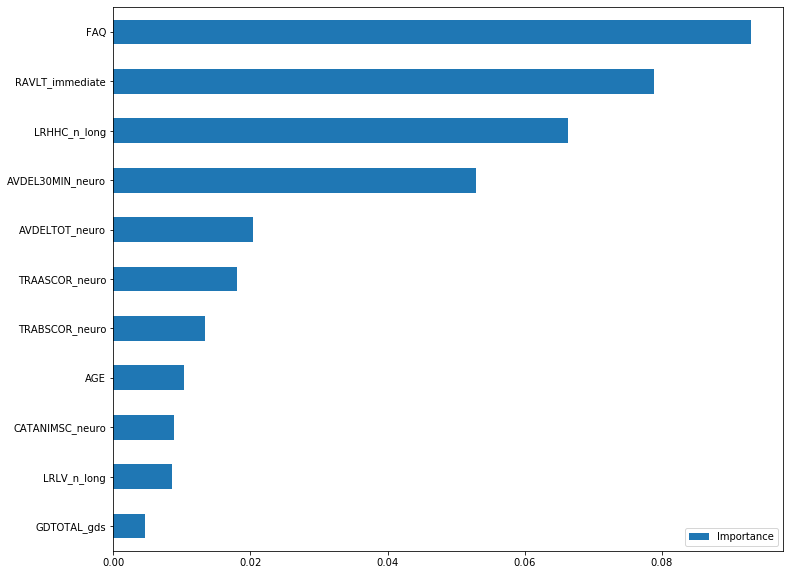

In [178]:
shap_imp_pd.sort_values(by=['Importance']).plot.barh(y='Importance', figsize=(12,10))